# "Will the SP-500 fall to index X by date Y"
> "a baseline forecast using python"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Tassilo Neubauer
- categories: [prediction, python]

I occasionally try to make predictions on the [forecasting Site Almanis](https://app.dysruptlabs.com). Some monthly recurring questions there are of the format: By date_X, will the S&P 500 fall below Index_Y? 

To get a baseline for my predictions I made this notebook. The main reason why I publish this on my blog now is that I want to get better at documenting and explaining it to others.

So let's get started! To make this example more concrete we will ask the question: "Will the S&P 500 go above 3900 by February 12th, 2021?"


When you want to make predictions, it is a good idea to look for how often something has occurred in the past. When it comes to an index like the S&P 500 it makes sense to make some kind of statistical model to inform your forecast, because this will outperform any forecast you are able to make with your intuition (here is a link to some sources I highly recommend, if you want to learn more about forecasting). 

So first a bit about markets: If you are a layperson like me, you should not expect to find an investing strategy to reliably earn money from the market through active investing. There are some caveats to this, but this is not what I am here to explain, so I'll just give you an example of what I mean: You should not believe any model you make that predicts that the S&P will go up or down tomorrow with a probability of 90% (which is enough confidence to make money by buying and selling the index fund). You should be pretty "humble" in this case because there are a bunch of firms employing people smarter and more knowledgeable about finance than you that are rewarded with any exploitable strategy they can find with a heap of money. This property is what people mean when they say a market is efficient. 
This is why we will assume for this model that the S&P 500 is a random walk, which means that daily price changes are independent of each other (Because any dependency in the price would be "Free money" that no one bothered to pick up which is unlikely"). This is not entirely true. But is good enough for the rough model we are aiming for here.
Because changes in a random walk are independent of each other means that the only information that we have about the future index is where the index stands right now.
So when we want to answer the question of whether the S&P 500 will exceed a certain index, we will look at the difference between the current index (3824,7) and the index that we want to know the probability of exceedance of (3900).

For example, what is the probability that the 
Of course, this probability can't be taken to be exact. To be precise, I looked at how 

This was useful for betting on questions on the betting Platform Almanis. Since the site asks those questions every month, I started to do this little analysis.

So first we import some standard libraries for data analysis

If you want you can download or execute it online with [Google Colab](https://colab.research.google.com/github/sonofhypnos/projects/blob/master/_notebooks/2020-01-10-sp500.ipynb). I downloaded the csv-file for the S&P 500 timeseries is from [Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC/history/).

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics as stg #we are going to use this later on to check our timeseries for autocorrelation
import statsmodels.api as sm
%matplotlib inline

df = pd.read_csv("https://raw.githubusercontent.com/sonofhypnos/projects/master/_notebooks/%5EGSPC.csv")


In [179]:
days_ahead = 15 # the number of days that the S&P has to stay within the boundary
boundary = 3400

In [180]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


As we can see this dataset goes back until 1927 which is pretty great for a free dataset. Another thing to notice here is that we only have data for the S&P on business days. Since this is only supposed to be a rough baseline forecast, we are going to ignore this fact and just pretend that the difference between Friday and Monday will be the same as between Tuesday and Wednesday. But we will still have to keep this fact in mind, so that our future forecast also only includes workdays.

In [181]:
sp = df.Close
sp.index = pd.to_datetime(df.Date)

In [182]:
sp.head()

Date
1927-12-30    17.660000
1928-01-03    17.760000
1928-01-04    17.719999
1928-01-05    17.549999
1928-01-06    17.660000
Name: Close, dtype: float64

Let's take a first look at our timeseries

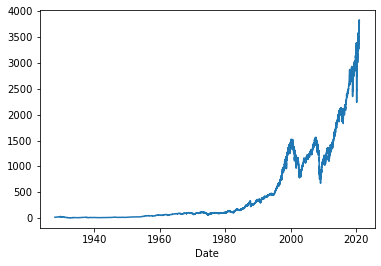

In [183]:
sns.lineplot(x=sp.index, y=sp.values);

As you can see the graph is growing exponentially. This is even more clear on a log scale:

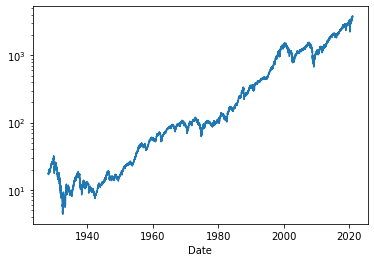

In [184]:
sns.lineplot(x=sp.index, y=sp.values)
plt.yscale("log")

We now take a closer look at the correlation in our graph. If our data could indeed be seen as a random walk, then there shouldn't be any correlation between consecutive days and this is indeed what we see:

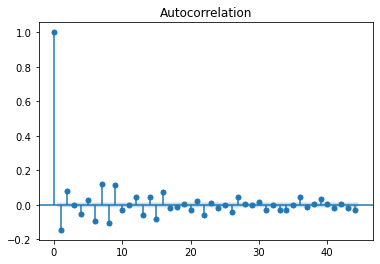

In [210]:
stg.tsaplots.plot_acf(sp_shifted[1:])
plt.show()

In [ ]:
sp_shifted.hist(bins=30)

As you can see the graph is roughly exponential


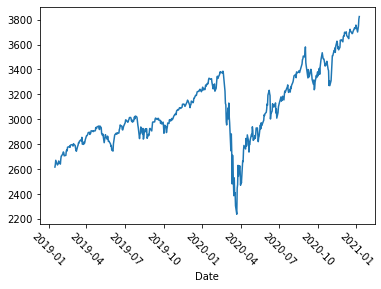

In [27]:
sns.lineplot(x=sp.index[-500:], y=sp.values[-500:])
plt.xticks(rotation=-45);

Now we also use the index collumn from our initial dataframe.

In [35]:
sp.head()

Date
1927-12-30    17.660000
1928-01-03    17.760000
1928-01-04    17.719999
1928-01-05    17.549999
1928-01-06    17.660000
Name: Close, dtype: float64

In [60]:
def relative_shift_n(ts, n):
    ts_shift = []
    for i in range(1,n+1):
        ts_shift.append((ts - ts.shift(periods=i))/ts)
    return ts_shift

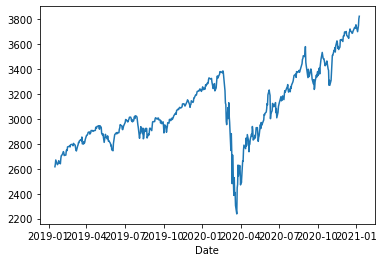

In [52]:
sns.lineplot(x=sp.index[-500:], y = sp.values[-500:]);

Now we specify the function to compute the number of workdays ahead.

In [136]:
def workdays_ahead(today, days_ahead):
    '''today is an integer from 0-4 specifying the workday'''
    days_to_weekend = today - 4 + (today % 4) #days until next weekend
    
    if days_to_weekend + 2>= days_ahead:
        if days_ahead - 2 >= 0:
            return days_ahead -2
        else: 
            return 0
    workdays = 5 * ((days_ahead - days_to_weekend - 2) // 7) + days_to_weekend
    print(workdays, days_ahead, days_to_weekend)
    if (days_ahead - days_to_weekend - 2) % 7 < 5:
        return workdays + (days_ahead - days_to_weekend - 2) % 7
    return workdays + 5

In [139]:
last_weekday = sp[-1:].index.weekday[0] 

n = workdays_ahead(last_weekday, days_ahead)

5 15 0


In [140]:
sp_shift = relative_shift_n(sp, n)
shift_index = [str(x) for x in range(1,n+1)]
sp_shift = pd.DataFrame.from_dict(dict(zip(shift_index,sp_shift)))
sp_shift = sp_shift[n:]

In [55]:
sp_shift

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Date,,,,,,,,,,,,,,,
1928-01-23,0.009070,0.014739,0.021542,0.019274,0.019841,0.003401,0.009637,0.016440,0.015306,0.007936,-0.001134,0.005102,-0.004535,-0.006803,-0.001134
1928-01-24,0.003953,0.012987,0.018634,0.025409,0.023151,0.023715,0.007340,0.013552,0.020327,0.019198,0.011858,0.002823,0.009034,-0.000565,-0.002823
1928-01-25,-0.010845,-0.006849,0.002283,0.007991,0.014840,0.012557,0.013128,-0.003425,0.002854,0.009703,0.008562,0.001142,-0.007991,-0.001712,-0.011415
1928-01-26,0.006239,-0.004538,-0.000567,0.008508,0.014180,0.020987,0.018718,0.019285,0.002836,0.009075,0.015882,0.014747,0.007374,-0.001702,0.004538
1928-01-27,0.003392,0.009610,-0.001130,0.002827,0.011871,0.017524,0.024308,0.022046,0.022612,0.006218,0.012437,0.019220,0.018089,0.010741,0.001696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-04,-0.014976,-0.008482,-0.007131,-0.009379,-0.000651,0.002875,0.003618,0.001548,-0.002367,-0.005899,-0.000141,0.001629,0.014365,0.010050,0.008796
2021-01-05,0.007033,-0.007838,-0.001390,-0.000048,-0.002281,0.006386,0.009888,0.010626,0.008570,0.004682,0.001175,0.006893,0.008651,0.021297,0.017012
2021-01-06,0.005677,0.012670,-0.002116,0.004295,0.005629,0.003410,0.012027,0.015509,0.016243,0.014199,0.010333,0.006846,0.012532,0.014279,0.026853


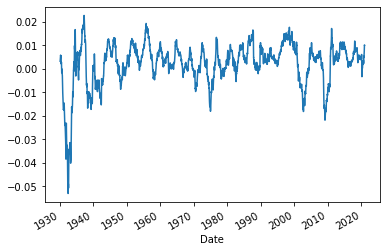

In [56]:
sp_shift["15"].rolling(window=500).mean().plot();

In [57]:
sp[-5:]

Date
2021-01-04    3700.649902
2021-01-05    3726.860107
2021-01-06    3748.139893
2021-01-07    3803.790039
2021-01-08    3824.679932
Name: Close, dtype: float64

In [58]:
float(sp[-1:])

3824.679932

probability of going below boundary
0.72931654676259


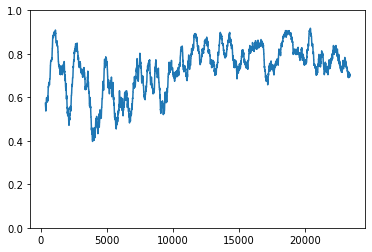

In [59]:
#computing the probability of exceeding "boundry"
sp_pre_forecast = float(sp[-1:]) + sp_shift * float(sp[-1:])

beyond_boundary = []
#change beyond boundary list based on whether our boundry is below 
# or above the current index of the S&P 500

if float(sp[-1:]) < boundary:
    print("probability of going above boundary")
    for i in range(len(sp_forecast)):
        beyond_boundary.append(any(sp_forecast.iloc[i] > boundary)) 
else:
    print("probability of going below boundary")
    for i in range(len(sp_forecast)):
        beyond_boundary.append(any(sp_forecast.iloc[i] < boundary))

beyond_boundary = pd.Series(beyond_boundary)

#output
print(beyond_boundary.mean())

beyond_boundary.rolling(window=365).mean().plot()
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()
    
boundary_prob()